In [2]:
import ast
from pathlib import Path

import contextily as cx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import libpysal as psl
import seaborn as sns
from pointpats import centrography, distance_statistics, QStatistic, random, PointPattern
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

# Analysis TFM Gasolineras

Las Gasolineras (solo las estaciones de servicio, no el n'umero de surtidores)

In [4]:
gaso = pd.read_csv(Path("data", "gasolineras.csv"), sep="\t")
gaso.latitud = gaso.latitud.apply(lambda x: ast.literal_eval(x.replace(",", ".")))
gaso.longitud = gaso.longitud.apply(lambda x: ast.literal_eval(x.replace(",", ".")))

In [6]:
gaso.head()

c.p.                                          dirección           horario  \
0  2250                     avenida castilla la mancha, 26  l-d: 07:00-22:00   
1  2152                                    cr cm-332, 46,4   l-d: 7:00-23:00   
2  2001                     calle federico garcia lorca, 1          l-d: 24h   
3  2001                     calle federico garcia lorca, 5  l-s: 05:00-23:00   
4  2001  calle principe de asturias (polígono de romica...  l-d: 06:00-22:00   

     latitud  localidad  longitud margen  municipio provincia  
0  39.211417  abengibre -1.539167      d  abengibre  albacete  
1  39.100389     alatoz -1.346083      i     alatoz  albacete  
2  39.000861   albacete -1.849833      d   albacete  albacete  
3  38.997722   albacete -1.846361      i   albacete  albacete  
4  39.054694   albacete -1.832000      i   albacete  albacete

In [7]:
gaso.provincia.unique()

array(['albacete', 'alicante', 'almería', 'araba/álava', 'asturias',
       'ávila', 'badajoz', 'balears (illes)', 'barcelona', 'bizkaia',
       'burgos', 'cáceres', 'cádiz', 'cantabria', 'castellón / castelló',
       'ceuta', 'ciudad real', 'córdoba', 'coruña (a)', 'cuenca',
       'gipuzkoa', 'girona', 'granada', 'guadalajara', 'huelva', 'huesca',
       'jaén', 'león', 'lleida', 'lugo', 'madrid', 'málaga', 'melilla',
       'murcia', 'navarra', 'ourense', 'palencia', 'palmas (las)',
       'pontevedra', 'rioja (la)', 'salamanca', 'santa cruz de tenerife',
       'segovia', 'sevilla', 'soria', 'tarragona', 'teruel', 'toledo',
       'valencia / valència', 'valladolid', 'zamora', 'zaragoza'],
      dtype=object)

Las electrolineras (Solo la estaci'on, no la cantidad de puntos de recarga)

In [5]:
elec = pd.read_csv(Path("data", "electrolineras.csv"), sep="\t")

In [8]:
elec.province.unique()

array(['Toledo', 'Balears, Illes', 'Alicante/Alacant', 'Asturias',
       'Barcelona', 'Palmas, Las', 'Santa Cruz de Tenerife', 'Girona',
       'Málaga', 'Murcia', 'Navarra', 'Bizkaia', 'Valencia/València',
       'Zaragoza', 'Coruña, A', 'Palencia', 'Tarragona', 'Salamanca',
       'Pontevedra', 'Madrid', 'Valladolid', 'Araba/Álava', 'Cantabria',
       'Segovia', 'Zamora', 'Ourense', 'Ávila', 'Badajoz', 'Burgos',
       'Gipuzkoa', 'Castellón/Castelló', 'Ciudad Real', 'Córdoba',
       'Cuenca', 'Granada', 'Huesca', 'León', 'Jaén', 'Lleida', 'Almería',
       'Guadalajara', 'Cádiz', 'Huelva', 'Rioja, La', 'Sevilla', 'Teruel',
       'Albacete', 'Cáceres', 'Lugo', 'Soria'], dtype=object)

In [9]:
elec.head()

id                                         name  \
0  2023002451                                HYC22BZ1873A-   
1  2023002088                  Centro Porsche Baleares CP2   
2  2023002089                  Centro Porsche Baleares CP1   
3  2023002112  Centro Porsche Alicante estación de carga 2   
4  2023002113  Centro Porsche Alicante estación de carga 1   

                          address              city          province  \
0  N-403, 2V, 45005 Toledo, Spain            Toledo            Toledo   
1              Camí dels Reis 166             Palma    Balears, Illes   
2              Camí dels Reis 166             Palma    Balears, Illes   
3             Carrer Riu Turia 16  Alicante/Alacant  Alicante/Alacant   
4             Carrer Riu Turia 16  Alicante/Alacant  Alicante/Alacant   

                   ccaa   latitude  longitude  
0  Castilla - La Mancha  39.872612  -4.040235  
1        Balears, Illes  39.594800   2.635860  
2        Balears, Illes  39.594800   2.635900  
3  Comunitat Valenciana  38.346600  -0.522950  
4  Comunitat Valenciana  38.346000  -0.523464

In [10]:
elec_canar = elec[elec.province.apply(lambda x: x in['Santa Cruz de Tenerife', 'Palmas, Las'])]
elec_penin = elec[~elec.province.apply(lambda x: x in['Santa Cruz de Tenerife', 'Palmas, Las'])]

In [79]:
elec_canar.loc[:, "province"] = elec_canar.province.apply(lambda x: "palmas (las)" if x == "Palmas, Las" else x.lower())

Dividir el estudio entre Canarias y Pen'insula para visualizar mejor los datos

In [11]:
gaso_canar = gaso[gaso.provincia.apply(lambda x: x in['santa cruz de tenerife', 'palmas (las)'])]
gaso_penin = gaso[~gaso.provincia.apply(lambda x: x in['santa cruz de tenerife', 'palmas (las)'])]

### Geo Data Frame Gasolineras

L'imites provinciales y de las CCAA: [aqu'i](https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE)

In [12]:
ccaa_shp = "SHP_REGCAN95/recintos_provinciales_inspire_canarias_regcan95/recintos_provinciales_inspire_canarias_regcan95.shp"
areas_canarias = gpd.read_file(ccaa_shp, encoding='utf-8')
areas_canarias.NAMEUNIT = areas_canarias.NAMEUNIT.apply(lambda x: x.lower())
areas_canarias.loc[0, "NAMEUNIT"] = "palmas (las)"
areas_canarias

INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34053500000      ES   
1  ES.IGN.BDDAE.34053800000      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34053500000   
1  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34053800000   

                 NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0            palmas (las)     ES7    ES70    None   
1  santa cruz de tenerife     ES7    ES70    None   

                                            geometry  
0  MULTIPOLYGON (((-15.69749 27.77109, -15.69750 ...  
1  MULTIPOLYGON (((-18.00161 27.64707, -18.00158 ...

In [45]:
ccaa_shp_2 = "SHP_ETRS89/recintos_provinciales_inspire_peninbal_etrs89/recintos_provinciales_inspire_peninbal_etrs89.shp"
areas_espania = gpd.read_file(ccaa_shp_2, encoding='utf-8')
areas_espania.NAMEUNIT = areas_espania.NAMEUNIT.apply(lambda x: x.lower())
areas_espania.loc[2, "NAMEUNIT"] = "alicante"
areas_espania.loc[6, "NAMEUNIT"] = "balears (illes)"
areas_espania.loc[11, "NAMEUNIT"] = "castellón / castelló"
areas_espania.loc[14, "NAMEUNIT"] = "coruña (a)"
areas_espania.loc[25, "NAMEUNIT"] = "rioja (la)"
areas_espania.loc[43, "NAMEUNIT"] = "valencia / valència"
areas_espania.head()

INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34160100000      ES   
1  ES.IGN.BDDAE.34080200000      ES   
2  ES.IGN.BDDAE.34100300000      ES   
3  ES.IGN.BDDAE.34010400000      ES   
4  ES.IGN.BDDAE.34070500000      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34160100000   
1  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34080200000   
2  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34100300000   
3  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34010400000   
4  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34070500000   

      NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0  araba/álava     ES2    ES21    None   
1     albacete     ES4    ES42    None   
2     alicante     ES5    ES52    None   
3      almería     ES6    ES61    None   
4        ávila     ES4    ES41    None   

                                            geometry  
0  POLYGON ((-2.76808 42.61408, -2.76863 42.61334...  
1  POLYGON ((-2.55212 38.08501, -2.55207 38.08517...  
2  MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37...  
3  MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35...  
4  POLYGON ((-5.43382 40.24491, -5.43430 40.24276...

In [39]:
# areas = pd.concat([areas_canarias.to_crs("epsg:4326"), areas_espania.to_crs("epsg:4326")])

## Patrones de puntos

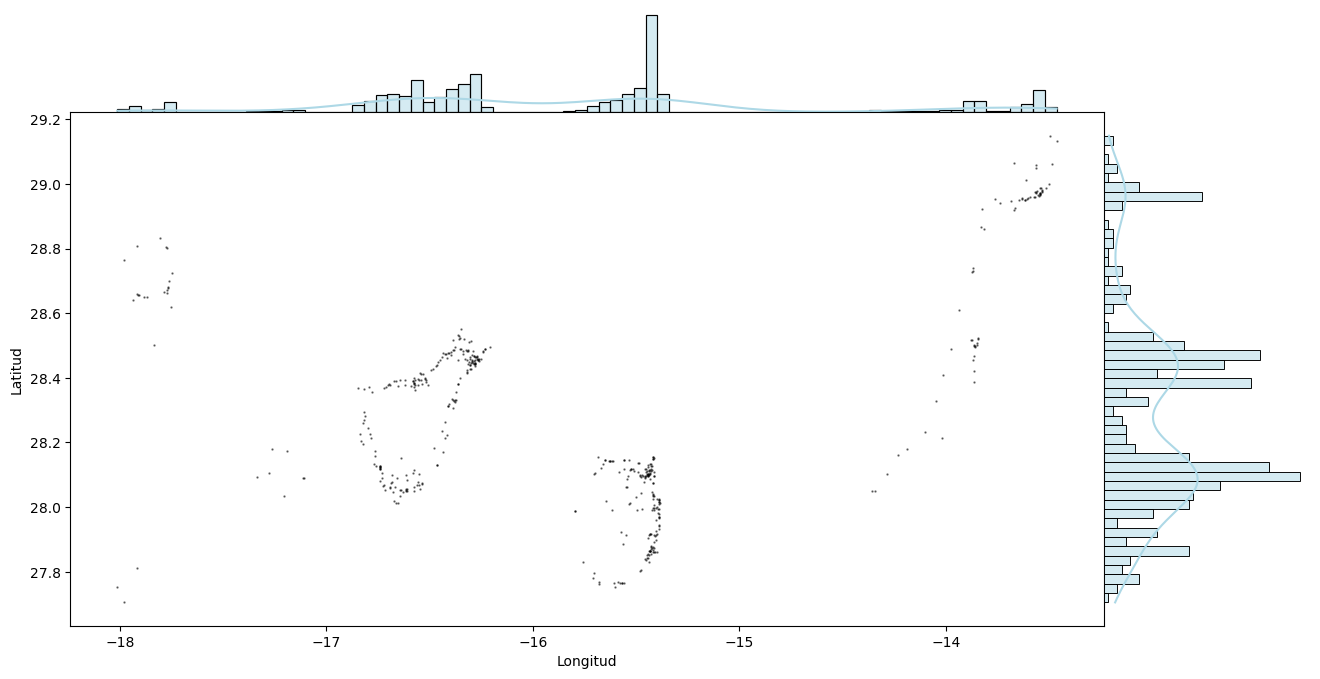

In [119]:
ver = 8
hor = ver * 2
fig, axs = plt.subplots(2, 2,
                        figsize=(hor, ver), 
                        gridspec_kw={
                            'hspace': 0, 
                            'wspace': 0, 
                            'width_ratios': [5, 1], 
                            'height_ratios': [1, 5]
                        })

axs[0,0].axis("off")  # arriba izquierda
axs[0,1].axis("off")  # arriva derecha
axs[1,1].axis("off")  # abajo derecha

axs[1,0].scatter(gaso_canar.longitud, 
                 gaso_canar.latitud, 
                 s=0.5, 
                 # c="xkcd:bright yellow", 
                 c="black",
                 alpha=0.5)
# axs[1,0].set_ylim(27.5, 29.5)
axs[1,0].set_xlabel("Longitud")
axs[1,0].set_ylabel("Latitud")
# cx.add_basemap(
#     axs[1,0], 
#     crs="EPSG:4326",
#     source=cx.providers.CartoDB.Voyager
#     # source=cx.providers.CartoDB.DarkMatter
# )

axv = sns.histplot(gaso_canar.longitud, bins=80, ax=axs[0,0], color="LightBlue", kde=True)
axh = sns.histplot(y=gaso_canar.latitud, bins=50, ax=axs[1,1], color="LightBlue", kde=True)



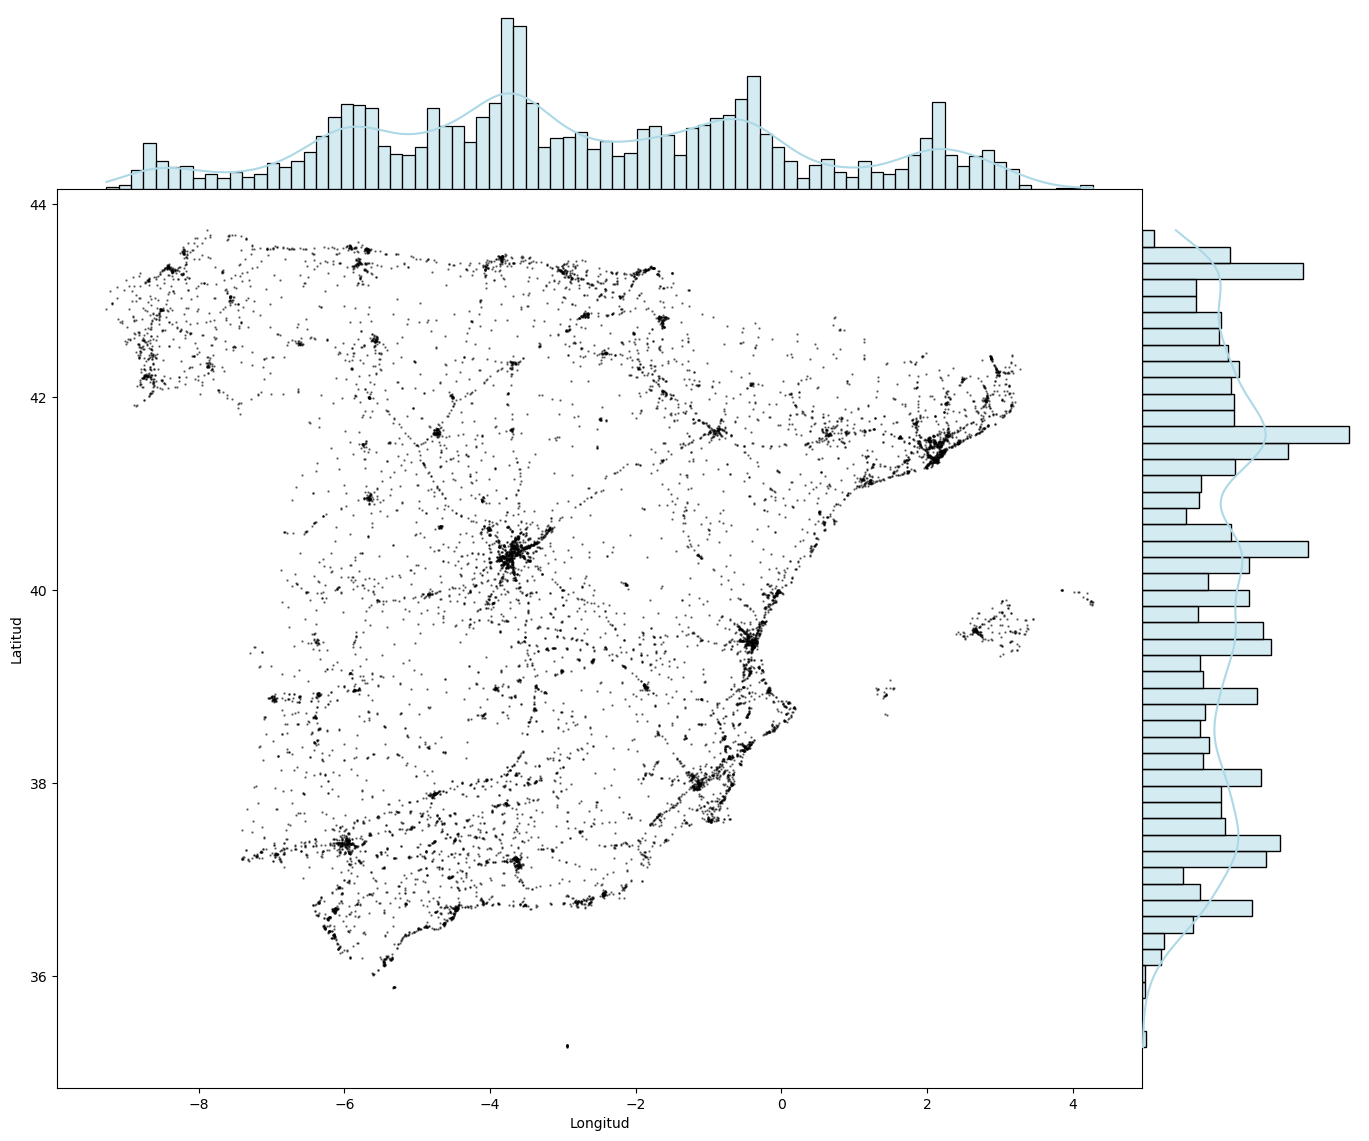

In [414]:
ver = 14
hor = ver * 1.2
fig, axs = plt.subplots(2, 2,
                        figsize=(hor, ver), 
                        gridspec_kw={
                            'hspace': 0, 
                            'wspace': 0, 
                            'width_ratios': [5, 1], 
                            'height_ratios': [1, 5]
                        })

axs[0,0].axis("off")  # arriba izquierda
axs[0,1].axis("off")  # arriva derecha
axs[1,1].axis("off")  # abajo derecha

axs[1,0].scatter(gaso_penin.longitud, 
                 gaso_penin.latitud, 
                 s=0.5, 
                 # c="xkcd:bright yellow", 
                 c="black",
                 alpha=0.5)
# axs[1,0].set_ylim(27.5, 29.5)
axs[1,0].set_xlabel("Longitud")
axs[1,0].set_ylabel("Latitud")
# cx.add_basemap(
#     axs[1,0], 
#     crs="EPSG:4326",
#     source=cx.providers.CartoDB.Voyager
#     # source=cx.providers.CartoDB.DarkMatter
# )

axv = sns.histplot(gaso_penin.longitud, bins=80, ax=axs[0,0], color="LightBlue", kde=True)
axh = sns.histplot(y=gaso_penin.latitud, bins=50, ax=axs[1,1], color="LightBlue", kde=True)

## Densidad de puntos

Text(0, 0.5, 'Gasolineras')

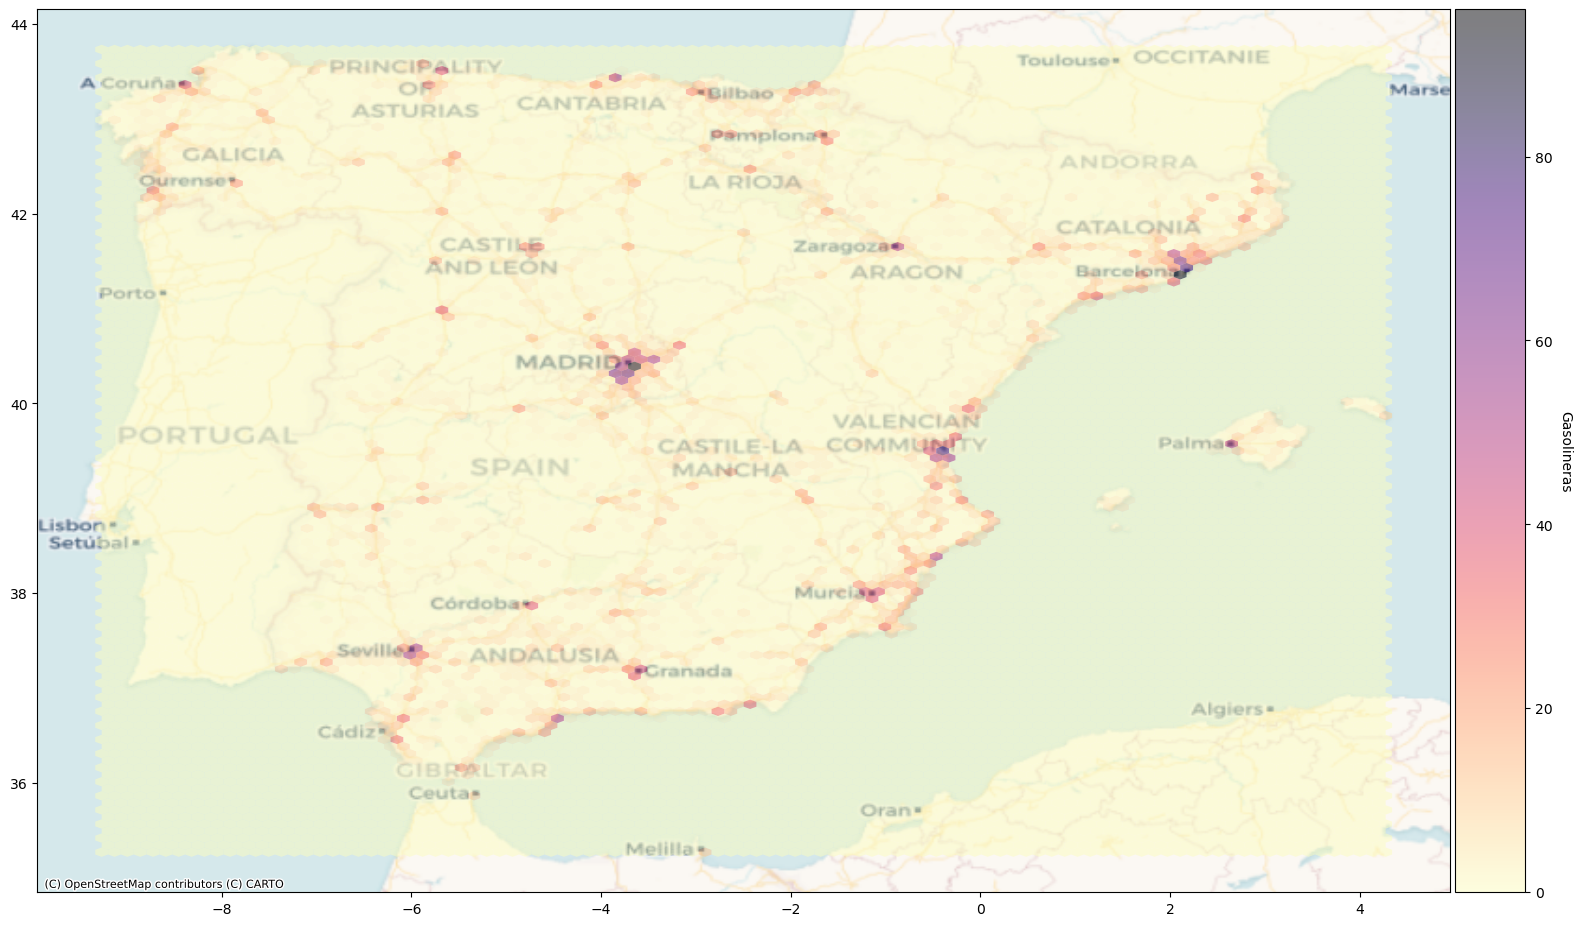

In [159]:
ver = 16
hor = ver * 1.2
f, ax = plt.subplots(1, figsize=(hor, ver))
hb = ax.hexbin(
    gaso_penin.longitud,
    gaso_penin.latitud,
    gridsize=100,
    linewidths=0,
    alpha=0.5,
    cmap="magma_r",
)
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Voyager
    # source=cx.providers.CartoDB.DarkMatter
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hb, cax=cax)
cbar.ax.set_ylabel("Gasolineras", rotation=-90, va="bottom")

## Estimaci'on de la densidad *kernel*

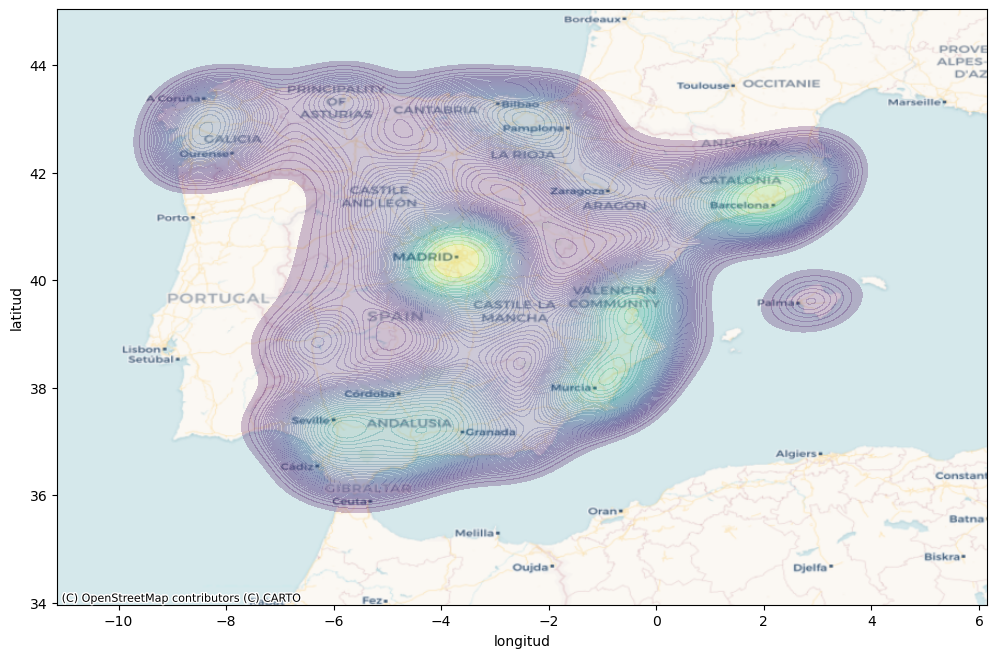

In [153]:
ver = 10
hor = ver * 1.2
f, ax = plt.subplots(1, figsize=(hor, ver))
sns.kdeplot(
    x='longitud', 
    y='latitud', 
    data=gaso_penin,
    n_levels=50, 
    fill=True,
    alpha=0.25,
    cmap="viridis"
)
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Voyager
    # source=cx.providers.CartoDB.DarkMatter
)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cbar = plt.colorbar(hb, cax=cax)
# cbar.ax.set_ylabel("Gasolineras", rotation=-90, va="bottom")

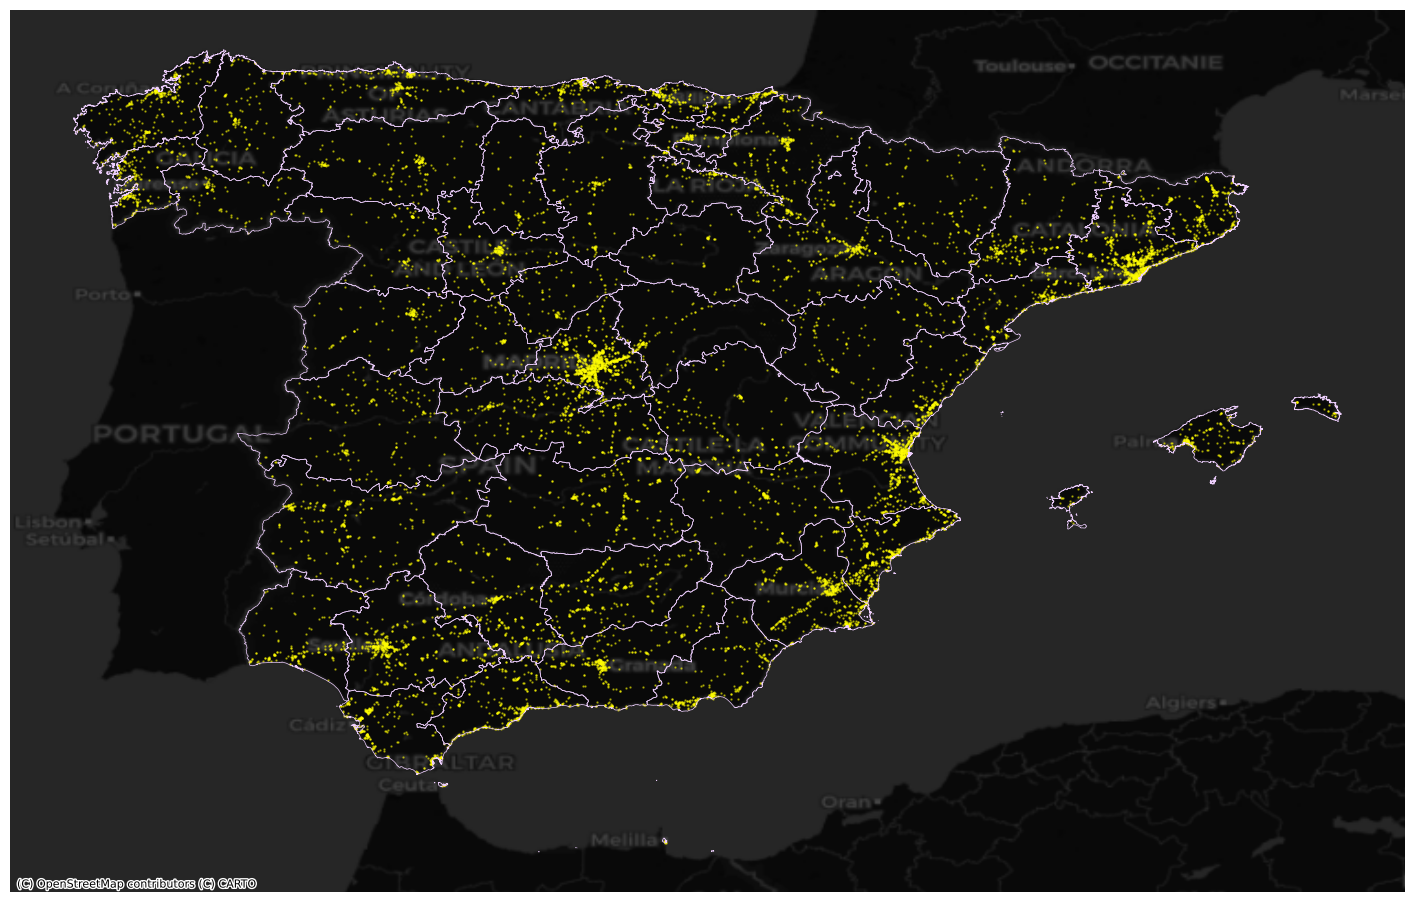

In [169]:
ver = 15
hor = ver * 1.2
# Plot photographs with smaller, more translucent dots
f, ax = plt.subplots(1, figsize=(hor, ver))
ax.scatter(gaso_penin.longitud, 
                 gaso_penin.latitud, 
                 s=0.5, 
                 c="xkcd:bright yellow", 
                 alpha=0.5)

# Add administrative boundaries
areas_espania.plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:pale lavender",
    linewidth=0.5
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

In [24]:

gasolineras = gaso_penin.groupby("provincia").size()
areas_espania_g = areas_espania.join(
    pd.DataFrame({"gasolineras": gasolineras}),
    on="NAMEUNIT"
)

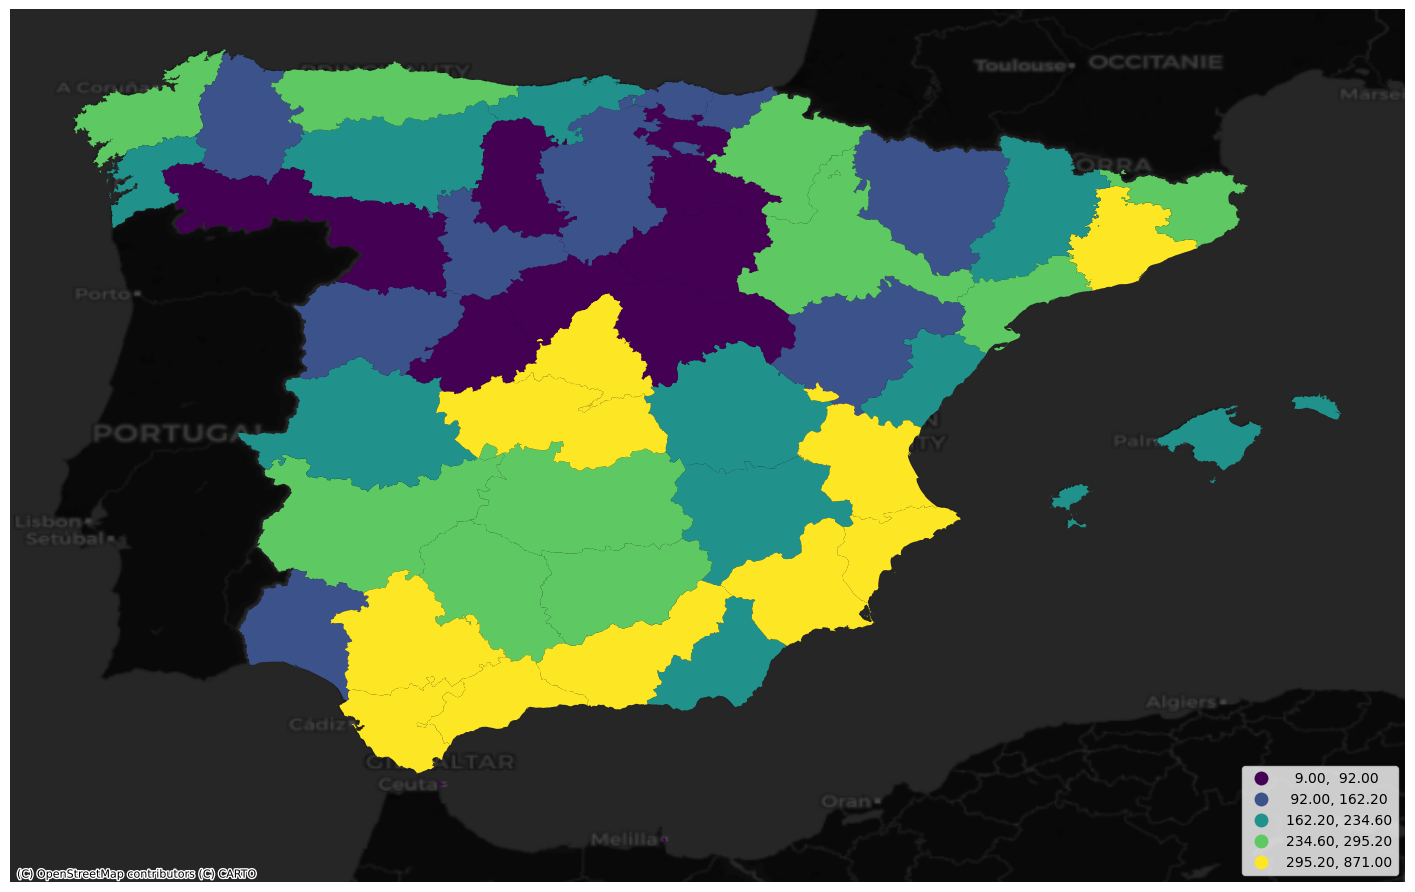

In [26]:
ver = 15
hor = ver * 1.2
# Plot photographs with smaller, more translucent dots
f, ax = plt.subplots(1, figsize=(hor, ver))
# ax.scatter(gaso_penin.longitud, 
#                  gaso_penin.latitud, 
#                  s=0.5, 
#                  c="xkcd:bright yellow", 
#                  alpha=0.5)

# Add administrative boundaries
areas_espania_g.plot(
    column='gasolineras', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

In [73]:
elec_penin.loc[:, "province"] = elec_penin.province.apply(lambda x: x.lower())
elec_penin.loc[:, "province"] = elec_penin.province.apply(lambda x: "alicante" if x == "alicante/alacant" else x)
elec_penin.loc[:, "province"] = elec_penin.province.apply(lambda x: "castellón / castelló" if x == "castellón/castelló" else x)
elec_penin.loc[:, "province"] = elec_penin.province.apply(lambda x: "rioja (la)" if x == "rioja, la" else x)
elec_penin.loc[:, "province"] = elec_penin.province.apply(lambda x: "valencia / valència" if x == "valencia/valència" else x)
elec_penin.loc[:, "province"] = elec_penin.province.apply(lambda x: "balears (illes)" if x == "balears, illes" else x)


electrolineras = elec_penin.groupby("province").size()
areas_espania_e = areas_espania.join(
    pd.DataFrame({"electrolineras": electrolineras}),
    on="NAMEUNIT"
)


In [74]:
indices = areas_espania_e[(areas_espania_e.NAMEUNIT == "ceuta") | (areas_espania_e.NAMEUNIT == "melilla")].index
areas_espania_e.loc[indices, "electrolineras"] = 0.0

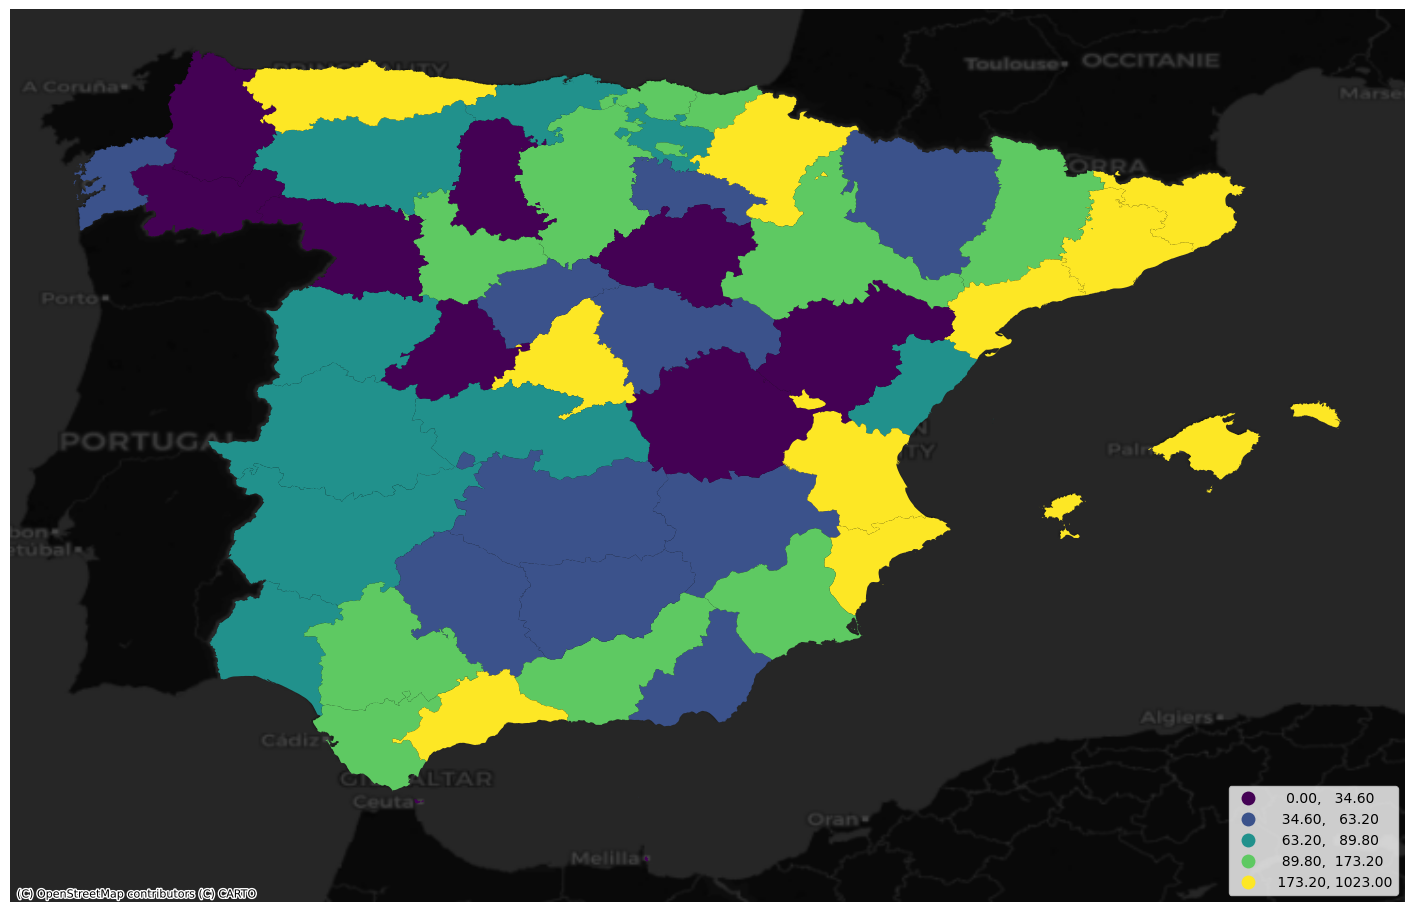

In [75]:
ver = 15
hor = ver * 1.2
# Plot photographs with smaller, more translucent dots
f, ax = plt.subplots(1, figsize=(hor, ver))
# ax.scatter(gaso_penin.longitud, 
#                  gaso_penin.latitud, 
#                  s=0.5, 
#                  c="xkcd:bright yellow", 
#                  alpha=0.5)

# Add administrative boundaries
areas_espania_e.plot(
    column='electrolineras', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

In [77]:
elec_canar.groupby("province").size()

province
Palmas, Las               110
Santa Cruz de Tenerife     63
dtype: int64

In [78]:
areas_canarias

INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34053500000      ES   
1  ES.IGN.BDDAE.34053800000      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34053500000   
1  https://inspire.ec.europa.eu/codelist/Administ...  Provincia  34053800000   

                 NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0            palmas (las)     ES7    ES70    None   
1  santa cruz de tenerife     ES7    ES70    None   

                                            geometry  
0  MULTIPOLYGON (((-15.69749 27.77109, -15.69750 ...  
1  MULTIPOLYGON (((-18.00161 27.64707, -18.00158 ...

## Centrograf'ia

Analisis por CCAA

#### Tendencia, Dispersi'on y Extensi'on

In [215]:
gaso_penin.provincia.unique()

array(['albacete', 'alicante', 'almería', 'araba/álava', 'asturias',
       'ávila', 'badajoz', 'balears (illes)', 'barcelona', 'bizkaia',
       'burgos', 'cáceres', 'cádiz', 'cantabria', 'castellón / castelló',
       'ceuta', 'ciudad real', 'córdoba', 'coruña (a)', 'cuenca',
       'gipuzkoa', 'girona', 'granada', 'guadalajara', 'huelva', 'huesca',
       'jaén', 'león', 'lleida', 'lugo', 'madrid', 'málaga', 'melilla',
       'murcia', 'navarra', 'ourense', 'palencia', 'pontevedra',
       'rioja (la)', 'salamanca', 'segovia', 'sevilla', 'soria',
       'tarragona', 'teruel', 'toledo', 'valencia / valència',
       'valladolid', 'zamora', 'zaragoza'], dtype=object)

In [110]:
gaso_prov = gaso_penin[
    (gaso_penin.provincia == "alicante")# | (gaso_penin.provincia == "castellón / castelló") | (gaso_penin.provincia == "valencia / valència")
]

In [111]:
mean_center = centrography.mean_center(gaso_prov[["longitud", "latitud"]])
med_center = centrography.euclidean_median(gaso_prov[["longitud", "latitud"]])
dispersion = centrography.std_distance(gaso_prov[["longitud", "latitud"]])
major, minor, rotation = centrography.ellipse(gaso_prov[["longitud", "latitud"]])

In [112]:
coordinates = gaso_prov[["longitud", "latitud"]].values
convex_hull_vertices = centrography.hull(coordinates)
alpha_shape, alpha, circs = psl.cg.alpha_shape_auto(coordinates, return_circles=True)

/tmp/ipykernel_104/1446291252.py:59: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = plt.gca().get_legend_handles_labels()


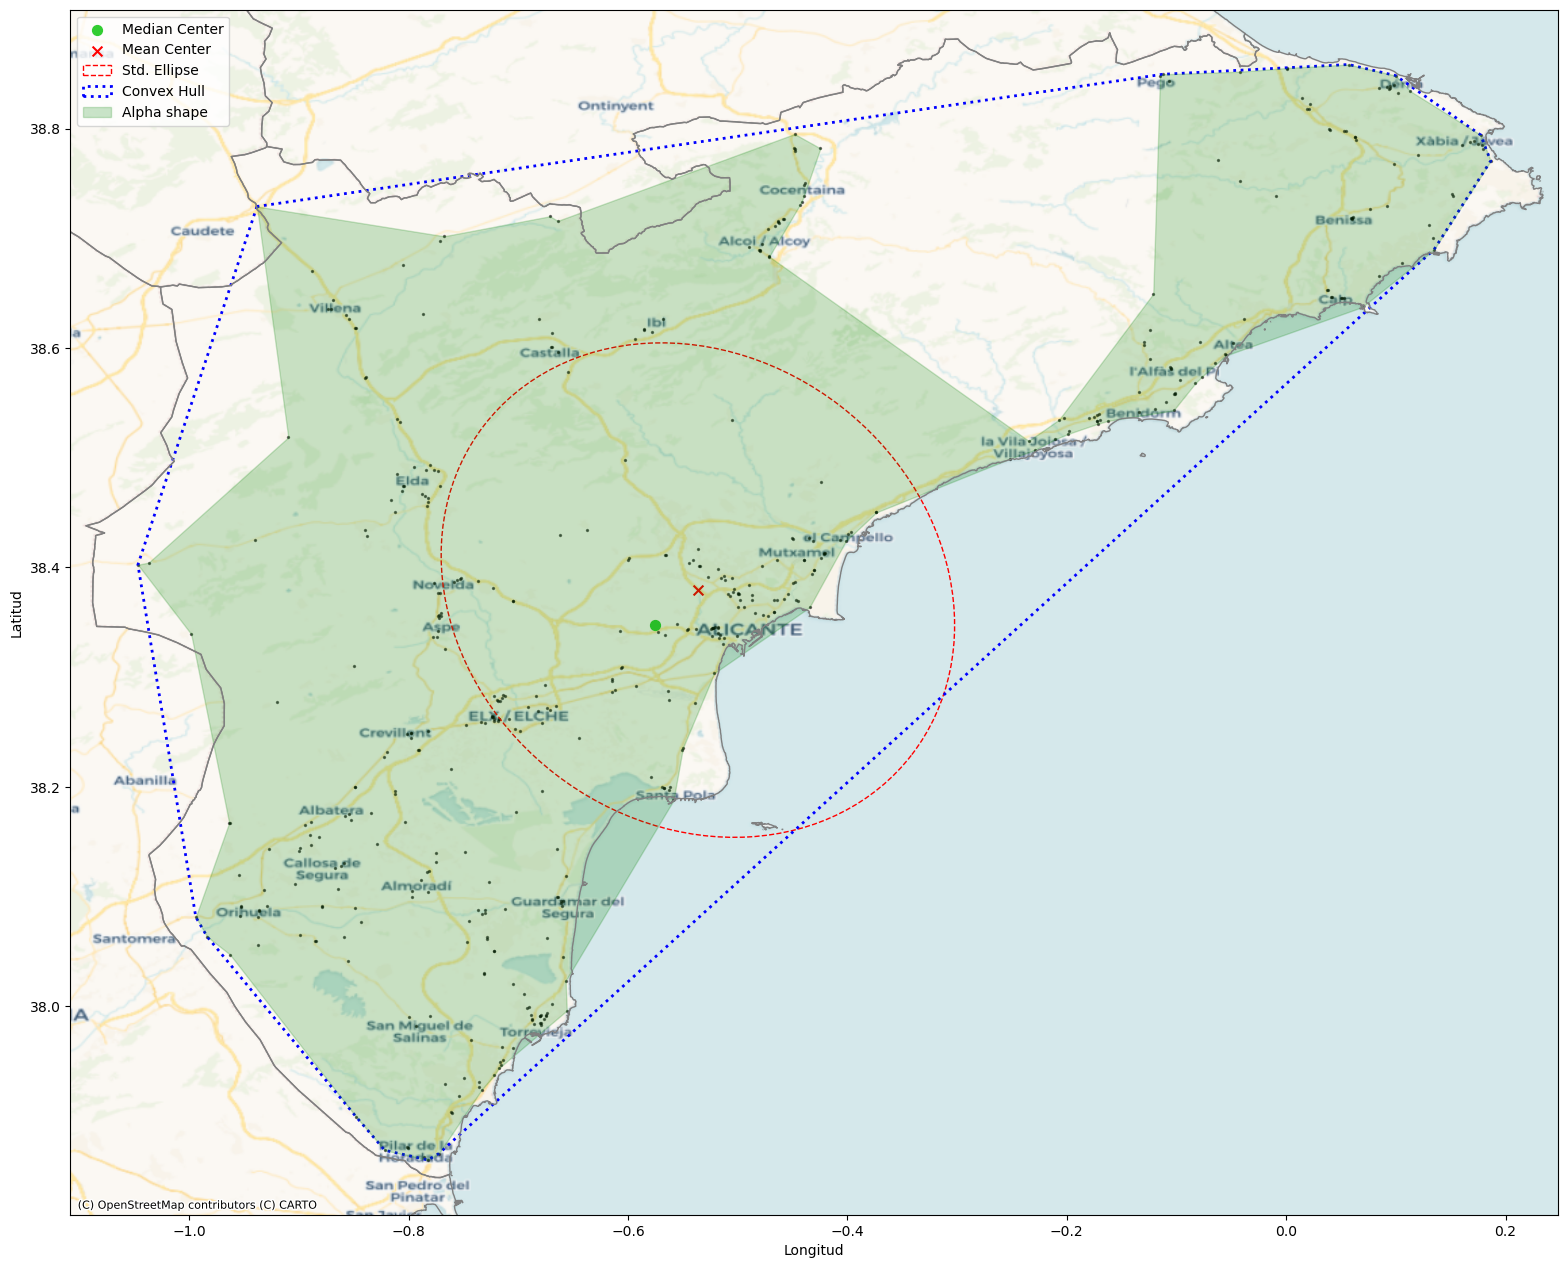

In [109]:
ver = 16
hor = ver * 1.2
fig, ax = plt.subplots(1, figsize=(hor, ver))

ax.scatter(gaso_prov.longitud, gaso_prov.latitud, s=2.0, c="black", alpha=0.5)

ax.scatter(*med_center, color="limegreen", marker="o", s=50, label="Median Center")
ax.scatter(*mean_center, color="red", marker="x", s=50.0, label="Mean Center")

ellipse = Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.rad2deg(rotation),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

ax.add_patch(
    plt.Polygon(
        convex_hull_vertices,
        closed=True,
        edgecolor="blue",
        facecolor="none",
        linestyle=":",
        linewidth=2,
        label="Convex Hull",
    )
)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

gpd.GeoSeries([alpha_shape]).plot(
    ax=ax,
    edgecolor="green",
    facecolor="green",
    alpha=0.2,
    label="Tightest single alpha shape",
)

ax_aer = areas_espania.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    linewidth=1.
)

ax_aer.set_xlim(x_lim)
ax_aer.set_ylim(y_lim)



handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([Patch(facecolor='g', edgecolor='g', label='Alpha shape', alpha=0.2)])
ax.legend(handles=handles, loc="upper left")

cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)

plt.savefig("pruebas.png")

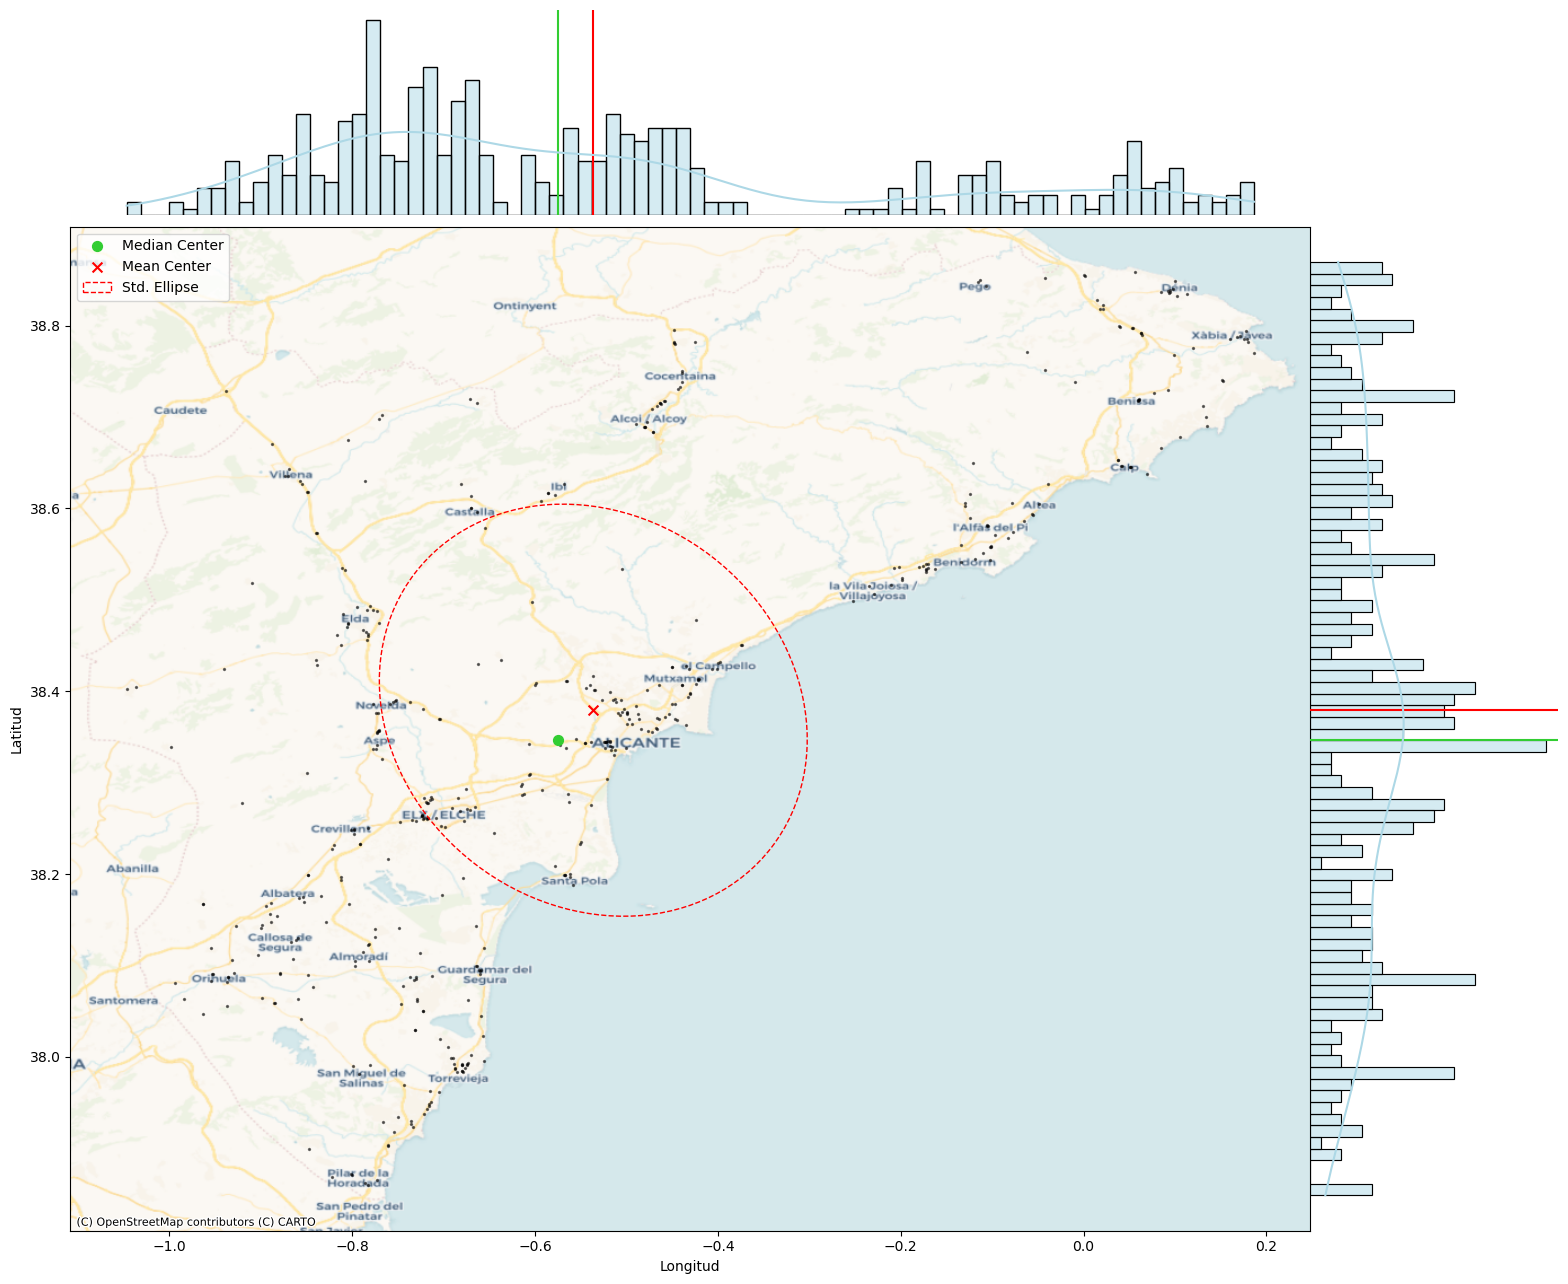

In [252]:
ver = 16
hor = ver * 1.2
fig, axs = plt.subplots(2, 2,
                        figsize=(hor, ver), 
                        gridspec_kw={
                            'hspace': 0, 
                            'wspace': 0, 
                            'width_ratios': [5, 1], 
                            'height_ratios': [1, 5]
                        })

axs[0,0].axis("off")  # arriba izquierda
axs[0,1].axis("off")  # arriva derecha
axs[1,1].axis("off")  # abajo derecha

axs[1,0].scatter(gaso_prov.longitud, 
                 gaso_prov.latitud, 
                 s=2.0, 
                 # c="xkcd:bright yellow", 
                 c="black",
                 alpha=0.5
                )

axs[1,0].scatter(*med_center, 
                 color="limegreen",
                 marker="o",
                 s=50,
                 label="Median Center")
axs[1,0].scatter(*mean_center, 
                 color="red", 
                 marker="x", 
                 s=50.0, 
                 label="Mean Center")

axs[0,0].axvline(mean_center[0], color="red")
axs[1,1].axhline(mean_center[1], color="red")

axs[0,0].axvline(med_center[0], color="limegreen")
axs[1,1].axhline(med_center[1], color="limegreen")

ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
axs[1,0].add_patch(ellipse)

axs[1,0].set_xlabel("Longitud")
axs[1,0].set_ylabel("Latitud")
axs[1,0].legend()

cx.add_basemap(
    axs[1,0], 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.Voyager
    # source=cx.providers.CartoDB.DarkMatter
)

axv = sns.histplot(gaso_prov.longitud, bins=80, ax=axs[0,0], color="LightBlue", kde=True)
axh = sns.histplot(y=gaso_prov.latitud, bins=80, ax=axs[1,1], color="LightBlue", kde=True)

Para electrolineras

In [99]:
elec_prov = elec_penin[elec_penin.province == "alicante"]


mean_center_e = centrography.mean_center(elec_prov[["longitude", "latitude"]])
med_center_e = centrography.euclidean_median(elec_prov[["longitude", "latitude"]])
major_e, minor_e, rotation_e = centrography.ellipse(elec_prov[["longitude", "latitude"]])

coordinates_e = elec_prov[["longitude", "latitude"]].values
convex_hull_vertices_e = centrography.hull(coordinates_e)
alpha_shape_e, alpha_e, circs_e = psl.cg.alpha_shape_auto(coordinates_e, return_circles=True)

/tmp/ipykernel_104/4154309847.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = plt.gca().get_legend_handles_labels()


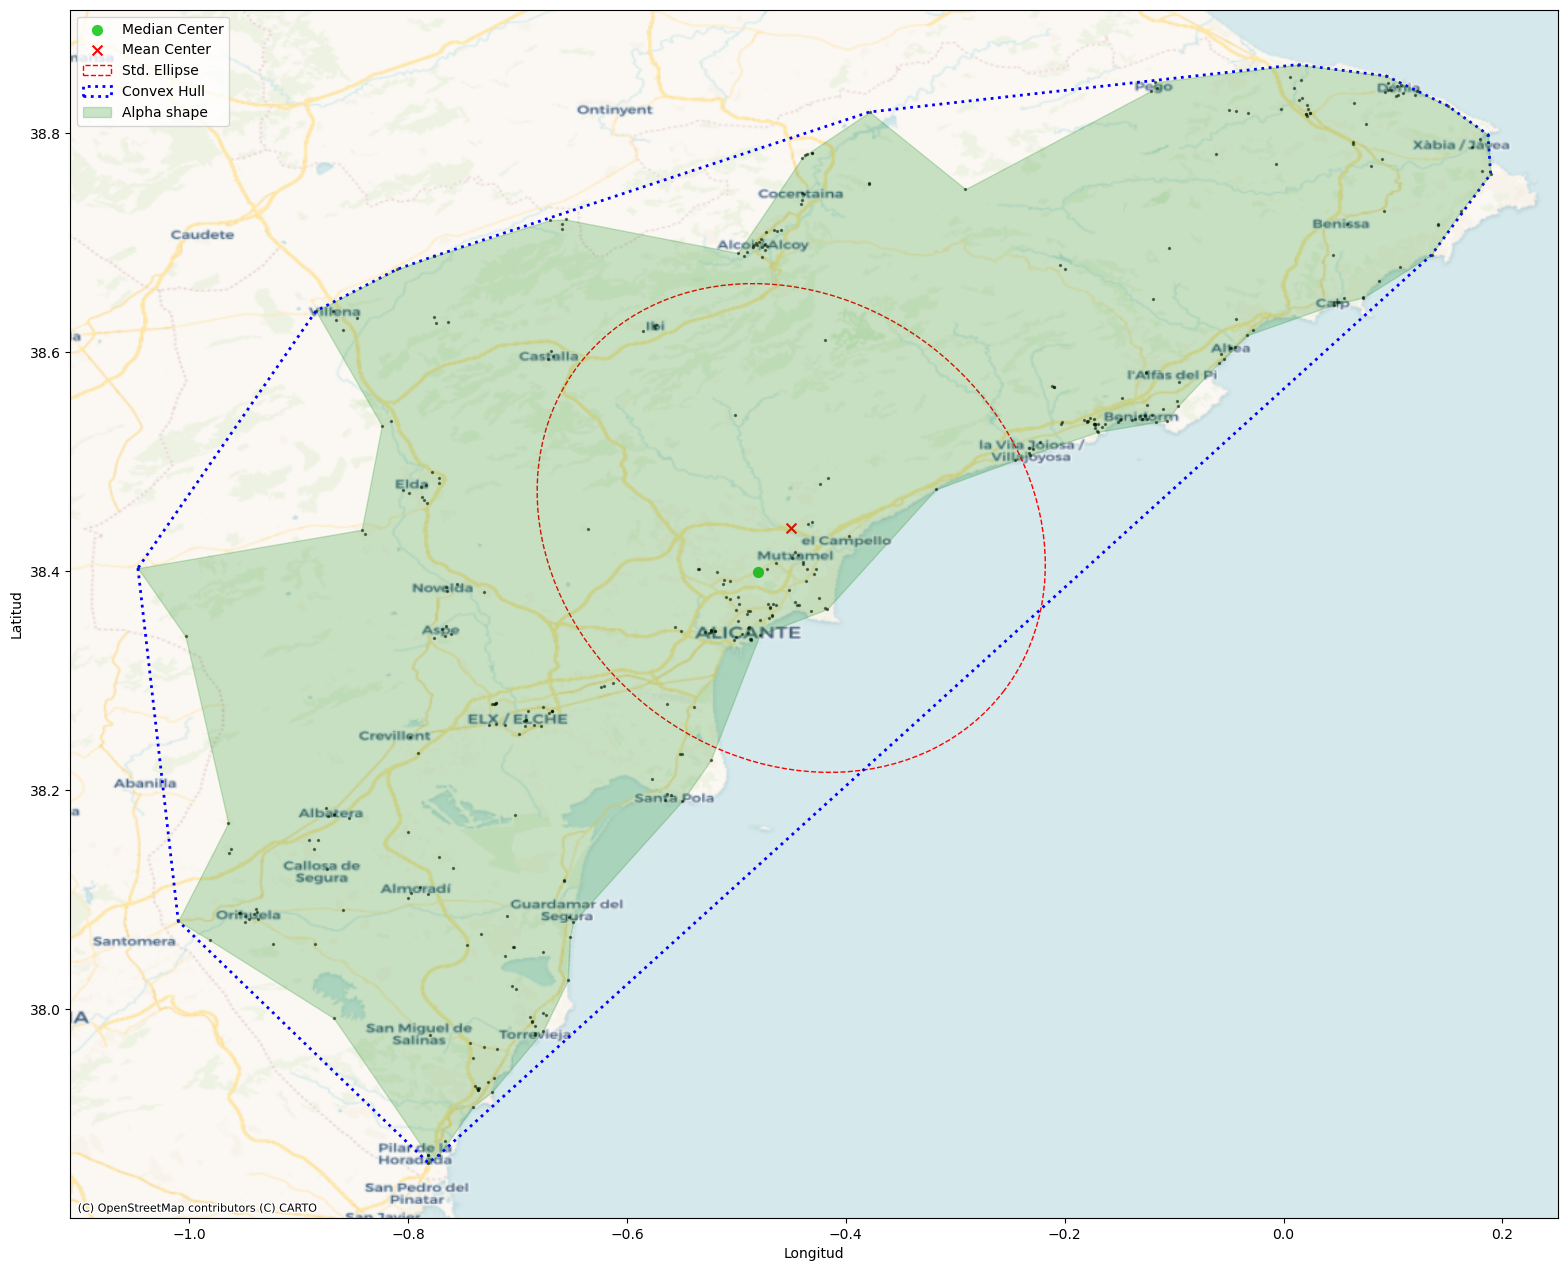

In [96]:
ver = 16
hor = ver * 1.2
fig, ax = plt.subplots(1, figsize=(hor, ver))

ax.scatter(elec_prov.longitude, elec_prov.latitude, s=2.0, c="black", alpha=0.5)

ax.scatter(*med_center_e, color="limegreen", marker="o", s=50, label="Median Center")
ax.scatter(*mean_center_e, color="red", marker="x", s=50.0, label="Mean Center")

ellipse_e = Ellipse(
    xy=mean_center_e,
    width=major_e * 2,
    height=minor_e * 2,
    angle=np.rad2deg(rotation_e),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse_e)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

ax.add_patch(
    plt.Polygon(
        convex_hull_vertices_e,
        closed=True,
        edgecolor="blue",
        facecolor="none",
        linestyle=":",
        linewidth=2,
        label="Convex Hull",
    )
)

gpd.GeoSeries([alpha_shape_e]).plot(
    ax=ax,
    edgecolor="green",
    facecolor="green",
    alpha=0.2,
    label="Tightest single alpha shape",
)

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([Patch(facecolor='g', edgecolor='g', label='Alpha shape', alpha=0.2)])
ax.legend(handles=handles, loc="upper left")

cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)

plt.savefig("pruebas.png")

Extensi'on

## Aleatoriedad y clustering

In [298]:
random_pattern = random.poisson(coordinates, size=len(coordinates))
# random_pattern_ashape = random.poisson(convex_hull_vertices, size=len(coordinates))
random_pattern_ashape = random.poisson(alpha_shape, size=len(coordinates))

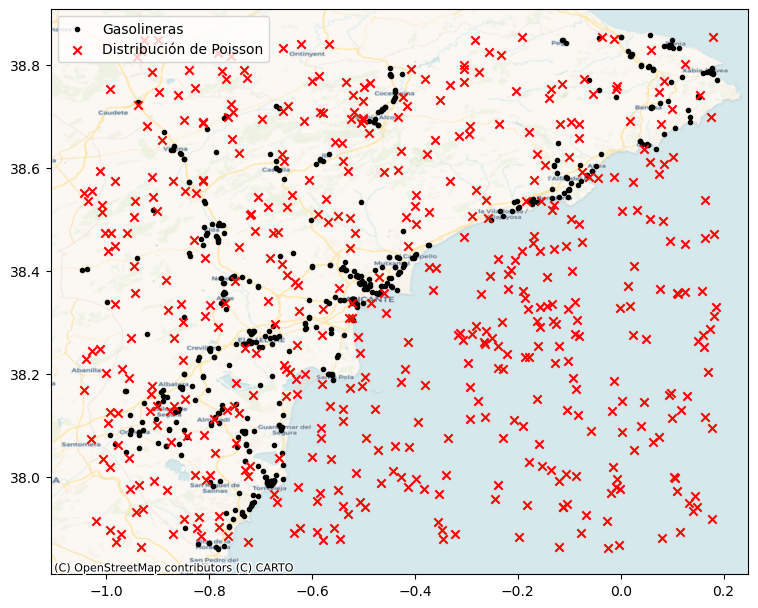

In [317]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Gasolineras"
)
ax.scatter(*random_pattern.T, color="r", marker="x", label="Distribución de Poisson")
cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)

ax.legend(ncol=1, loc="upper left")

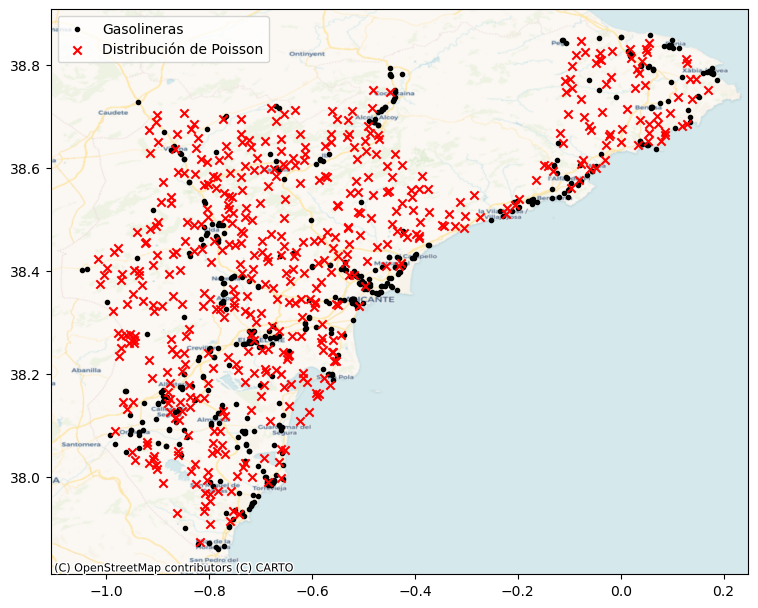

In [299]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Gasolineras"
)
ax.scatter(*random_pattern_ashape.T, color="r", marker="x", label="Distribución de Poisson")
cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)

ax.legend(ncol=1, loc="upper left")

#### Quadrat statistics

[`QStatistic`](https://pysal.org/pointpats/generated/pointpats.QStatistic.html)

<Axes: title={'center': 'Quadrat Count'}>

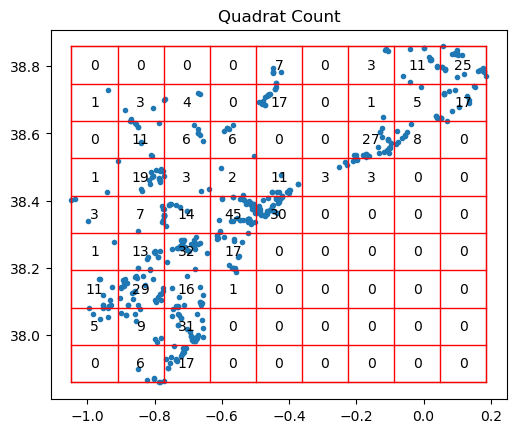

In [304]:
qstat = QStatistic(coordinates, nx=9, ny=9)
qstat.plot()

In [305]:
qstat.chi2_pvalue

6.262363327584735e-207

<Axes: title={'center': 'Quadrat Count'}>

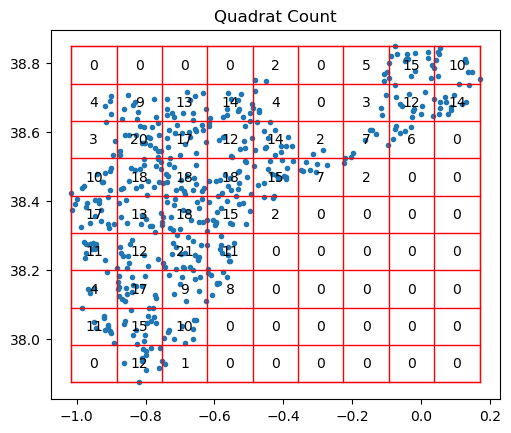

In [311]:
qstat_null = QStatistic(random_pattern_ashape, nx=9, ny=9)
qstat_null.plot()

In [312]:
qstat_null.chi2_pvalue

2.0585579704890428e-84

<Axes: title={'center': 'Quadrat Count'}>

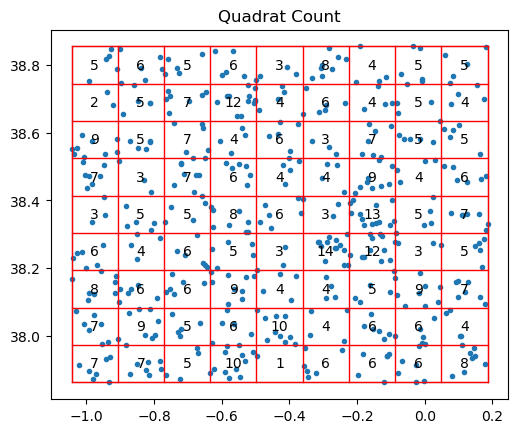

In [315]:
qstat_null = QStatistic(random_pattern, nx=9, ny=9)
qstat_null.plot()

In [316]:
qstat_null.chi2_pvalue

0.5558314267274197

#### Ripley’s alphabet of functions

In [318]:
g_test = distance_statistics.g_test(coordinates, support=40, keep_simulations=True)

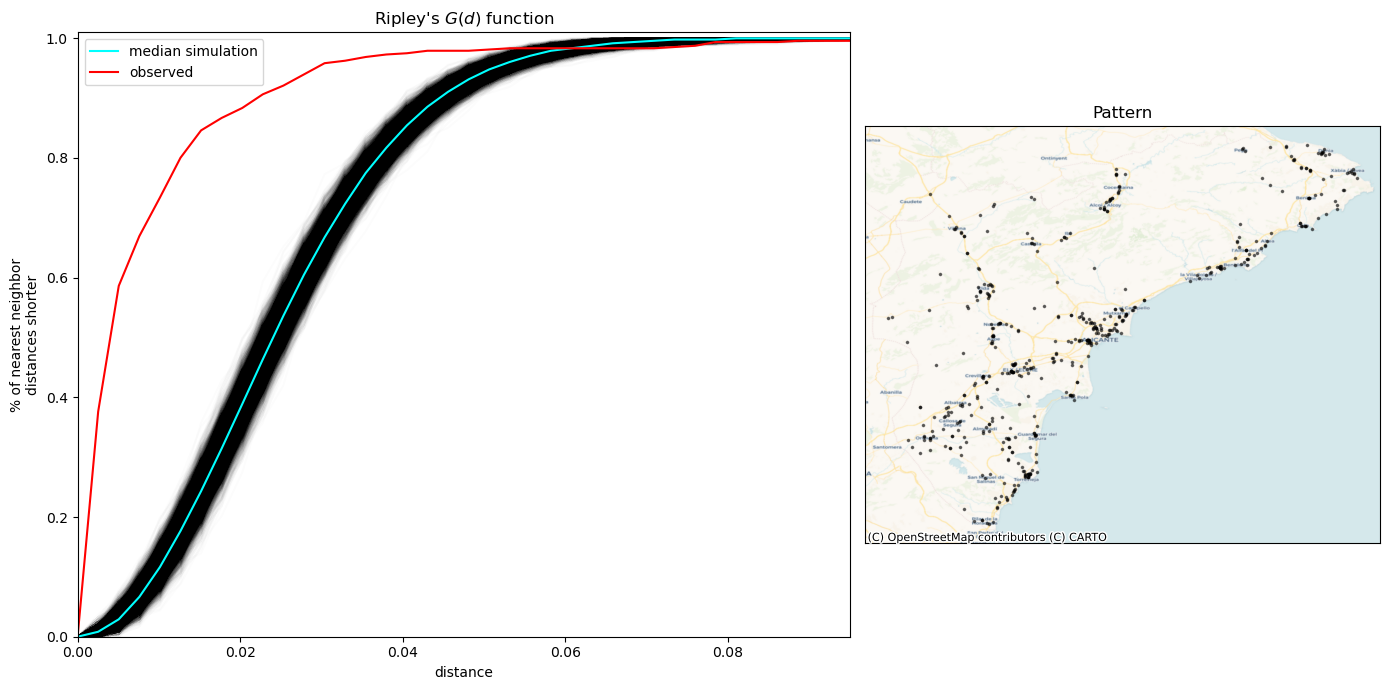

In [332]:
ver = 7
hor = ver * 2
f, ax = plt.subplots(1, 2, figsize=(hor, ver), gridspec_kw=dict(width_ratios=(6, 4)))
# plot all the simulations with very fine lines
ax[0].plot(g_test.support, g_test.simulations.T, color="k", alpha=0.01)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    np.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(g_test.support, g_test.statistic, label="observed", color="red")

ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 0.095)
ax[0].set_ylim(0, 1.01)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T, color="k", alpha=0.5, s=2.5)
cx.add_basemap(ax[1], crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()

In [333]:
f_test = distance_statistics.f_test(coordinates, support=40, keep_simulations=True)

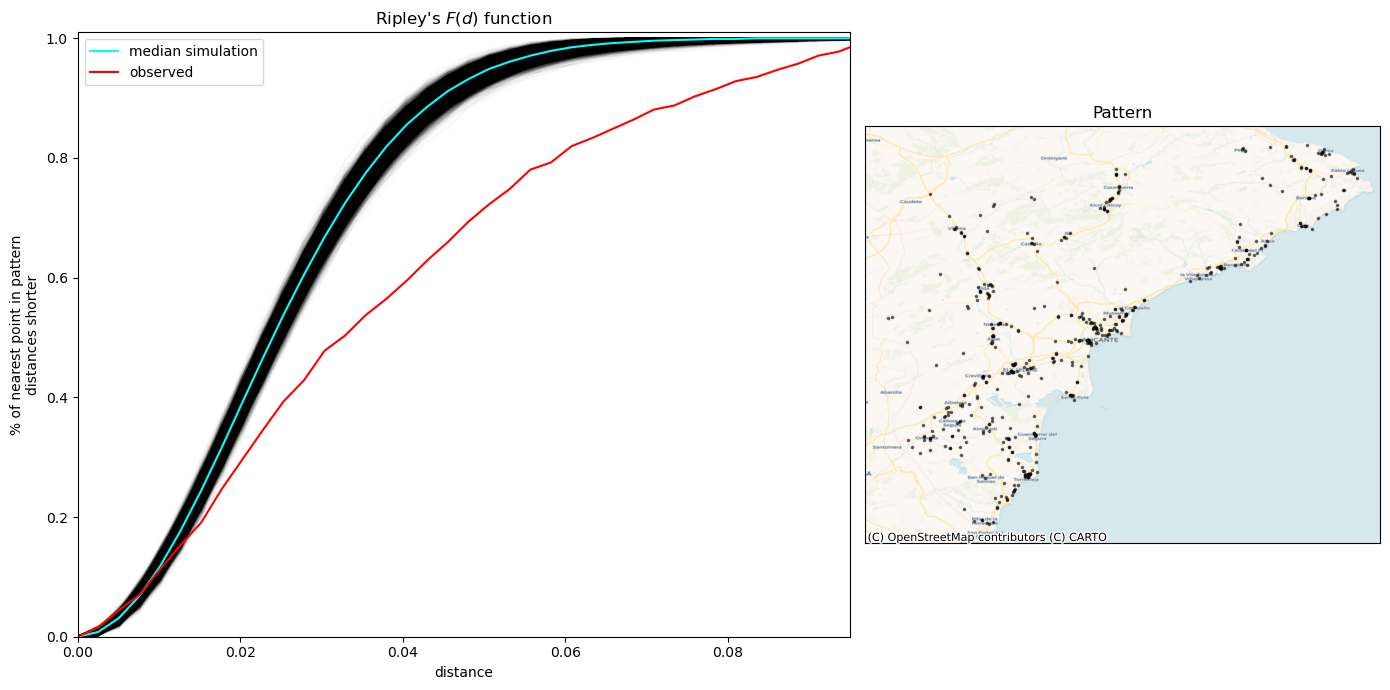

In [336]:
ver = 7
hor = ver * 2
f, ax = plt.subplots(1, 2, figsize=(hor, ver), gridspec_kw=dict(width_ratios=(6, 4)))

# plot all the simulations with very fine lines
ax[0].plot(f_test.support, f_test.simulations.T, color="k", alpha=0.01)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    np.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's F function
ax[0].plot(f_test.support, f_test.statistic, label="observed", color="red")

ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 0.095)
ax[0].set_ylim(0, 1.01)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T, color="k", alpha=0.5, s=2.5)
cx.add_basemap(ax[1], crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()

## Clustering

[sklearn](https://scikit-learn.org/1.5/modules/clustering.html)

M'etodo de elbow para saber el n'umero de clusters

Text(0.5, 1.0, 'Elbow Method For Optimal k')

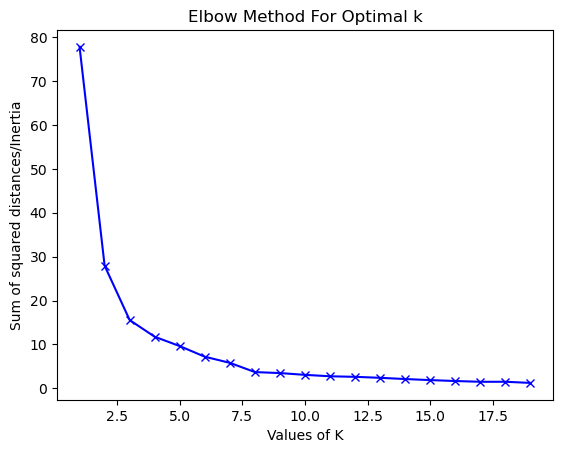

In [382]:
Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(gaso_prov[["latitud", "longitud"]])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")

Text(0.5, 1.0, 'Silhouette analysis For Optimal k')

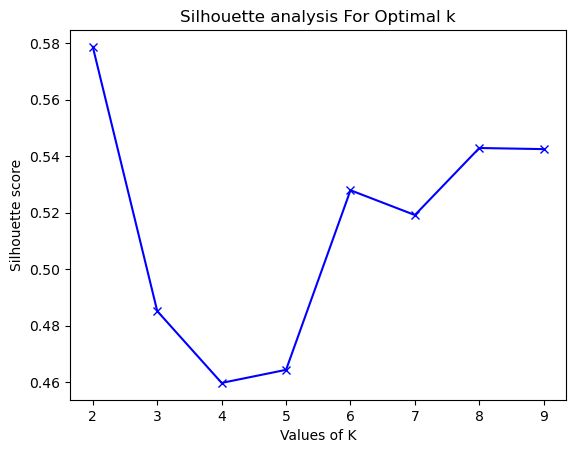

In [406]:
silhouette_avg = []
for num_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(gaso_prov[["latitud", "longitud"]])
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(gaso_prov[["latitud", "longitud"]], cluster_labels))

plt.plot(range(2, 10), silhouette_avg, "bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")

In [410]:
# clusterer = DBSCAN(eps=0.3, min_samples=10)
clusterer = KMeans(n_clusters=8, random_state=0, n_init="auto")
clusterer.fit(gaso_prov[["latitud", "longitud"]])

KMeans(random_state=0)

In [411]:
# lbls = pd.Series(clusterer.labels_, index=gaso_prov.index)
df_prov = gaso_prov[["latitud", "longitud"]]
df_prov.loc[:, ["lavels"]] = clusterer.labels_

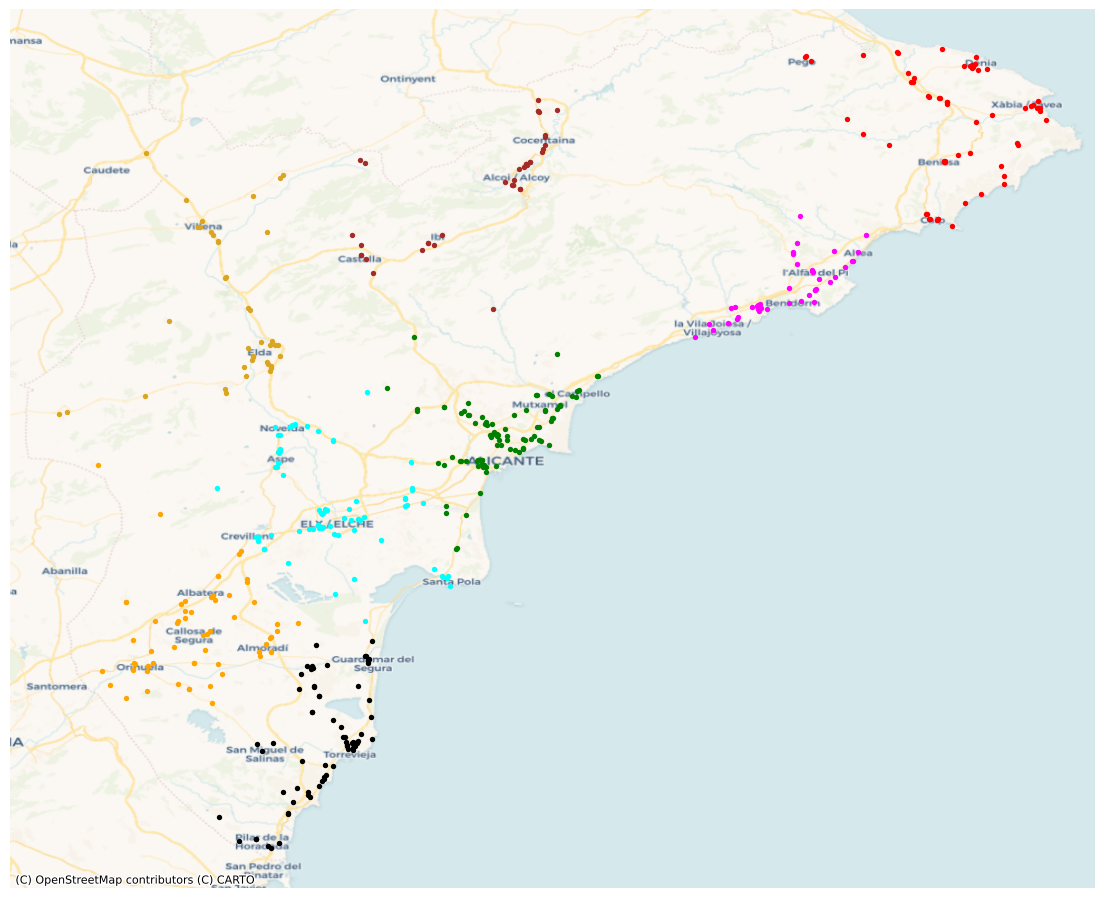

In [412]:
s = 14
f, ax = plt.subplots(1, figsize=(s, s))
colors = ["black", "red", "brown", "orange", "green", "goldenrod", "aqua", "magenta"]

# noise = gaso_prov.loc[lbls == 1, ["longitud", "latitud"]]
for k in df_prov.lavels.unique():
    ax.scatter(
        df_prov[df_prov["lavels"] == k].longitud,
        df_prov[df_prov["lavels"] == k].latitud,
        c=colors[k],
        s=15,
        linewidth=0,
    )

# ax.scatter(noise["longitud"], noise["latitud"], c="g", s=5, linewidth=0)
# ax.scatter(
#     gaso_prov.loc[gaso_prov.index.difference(noise.index), "longitud"],
#     gaso_prov.loc[gaso_prov.index.difference(noise.index), "latitud"],
#     c="r",
#     s=3,
#     linewidth=0,
# )
cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)


ax.set_axis_off()

[Otra](https://github.com/youssefHosni/Practical-Machine-Learning/blob/main/How%20to%20Find%20the%20Optimal%20Number%20of%20Clusters%20Effectively.ipynb) forma de buscar el par'ametro K. Y m'as [informacion](https://domino.ai/blog/getting-started-with-k-means-clustering-in-python).